In [4]:
def isNaN(num):
    return num != num

Numbers
[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
[3, 508, 5, 504, 1507, 1515, 1030, 1031, 1539, 1038, 2007, 22, 2004, 1002]
[1000, 1505, 1997, 3496, 7492, 13735, 11740, 9238, 10736, 10238, 11735, 10981, 11980, 7585]


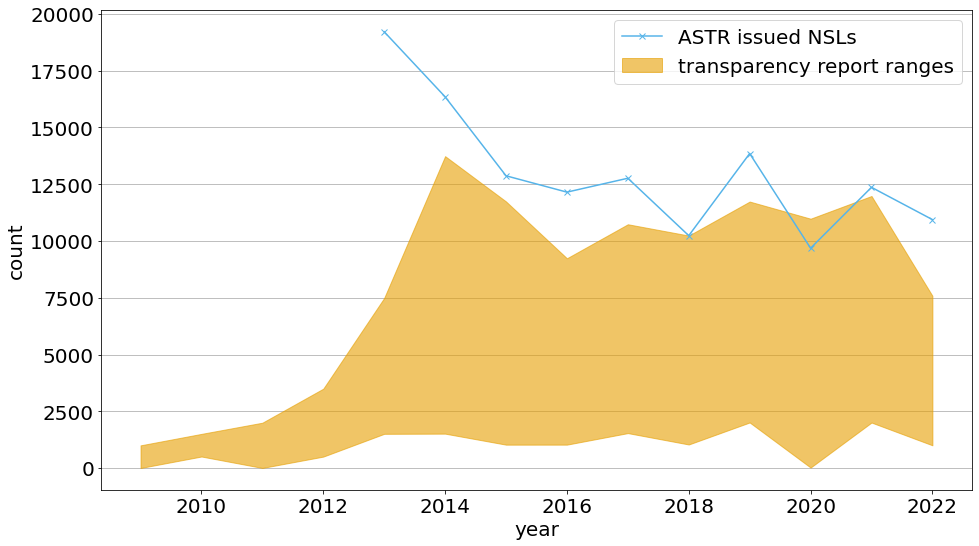

In [5]:
#!/usr/bin/python3
# This file plots the number of issued NSLs (from fisa_astr_data.csv) as well as the band of NSLs received by companies.
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

# Load data from dir
DATA_DIR = "../../data/extracted"
df_nsl = pd.read_csv("{}/{}".format(DATA_DIR, "fisa_astr_data.csv")).set_index("year")
df_transparency_records = pd.read_csv("{}/{}".format(DATA_DIR,"transparency_reports_extended.csv"))

# Some companies combine their NSL and FISA numbers. We ignore them in this plot.
# These companies are noted in the "transparency_records.csv" with keywords "combine" / "Combine"
keywords = ["combine", "Combine"]
for keyword in keywords:
    # ignore all companies whose notes contain the keyword
    df_transparency_records = df_transparency_records[~df_transparency_records["Notes"].str.contains(keyword, na=False)]

# values for X axies
transparency_report_x_axis_val = []
# min number of possible NSLs
transparency_report_range_min_per_year = []
# max number of possible NSLs
transparency_report_range_max_per_year = []
for year in range(2009, 2023, 1):
    transparency_report_x_axis_val.append(year)
    sum_min_this_year = 0
    sum_max_this_year = 0
    # iterate over all numbers reported in a year
    for cell_value in df_transparency_records[str(year)]:     
        # ignore nan or single value (not allowed)
        if isNaN(cell_value) or isinstance(cell_value,float):
            if isinstance(cell_value,float):
                if cell_value == 0.0:
                    print(year, cell_value)
            continue

        # handle the number of NSLs reported by the companies.
        # possible values:
            # a range: 0-100
            # two ranges: 500-999, 4-499
        # print(cell_value)
        for r in cell_value.split(","):
            # ignore dash or invalid data format
            if r in ["-", " ", ""]:
                continue
            # get the range
            parts = r.split("-")
            if len(parts) == 1:
                lower = high = int(parts[0])
            elif len(parts) == 2:
                lower, high = int(parts[0]), int(parts[1])
            else:
                print("inconsistent data, line:", cell_value, "expected ranges like 0-225")
                exit(1)
            sum_min_this_year += lower
            sum_max_this_year += high
    transparency_report_range_min_per_year.append(sum_min_this_year)
    transparency_report_range_max_per_year.append(sum_max_this_year)

print("Numbers")
print(transparency_report_x_axis_val)
print(transparency_report_range_min_per_year)
print(transparency_report_range_max_per_year)

colors_wong = [
    "#000000", "#e69f00", "#56b4e9", "#009e73",
    "#f0e442", "#0072b2", "#d55e00", "#cc79a7"
]

# plot the results
RESULTS_DIR = "../../data/processed"

plt.rc("axes", axisbelow=True)
plt.rcParams["font.size"] = 20
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)
plt.figure()
# plot nsl numbers
df_nsl["ASTR issued NSLs"].plot(marker="x", color=colors_wong[2])
plt.grid(axis="y")
# plot ranges derived from transparency report
plt.fill_between(transparency_report_x_axis_val, transparency_report_range_min_per_year, transparency_report_range_max_per_year, color=colors_wong[1], alpha=0.6, label='transparency report ranges')
plt.xlabel("year")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.savefig("{}/transparency_reports.pdf".format(RESULTS_DIR))
plt.savefig("{}/transparency_reports.png".format(RESULTS_DIR))
plt.show()
